# Bibliotecas

Primero importamos las bibliotecas necesarias:

In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 8

# Preprocesado y modelado
# ------------------------------------------------------------------------------
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from joblib import Parallel, delayed, cpu_count
# Explicabilidad
import shap

# Configuración warnings
# ------------------------------------------------------------------------------
import multiprocessing
import warnings
warnings.filterwarnings('once')

# Lectura de los dataset y transformaciones

In [2]:
# Especificamos la ruta del archivo Excel
ruta_archivo_excel = 'Data_2 - copia.xlsx'

# Leemos todas las hojas del archivo Excel en un diccionario de DataFrames
P_data = pd.read_excel(ruta_archivo_excel, sheet_name='Product DATA')
T_data = pd.read_excel(ruta_archivo_excel, sheet_name='Transaction DATA')
B_data = pd.read_excel(ruta_archivo_excel, sheet_name='Budget Data')
W_data = pd.read_excel(ruta_archivo_excel, sheet_name='Weather DATA')

In [3]:
# Eliminamos todas las filas que pertenezcan a productos distintos de ['PROD_00001', 'PROD_00002', 'PROD_00004']
P_data = P_data[P_data['PROD_ID'].isin([1, 2, 4])]

In [4]:
# Quitamos las filas con horas fuera de horario de parque (12.0-20.0)
W_df = W_data[(W_data['WEATHER_HOUR'] <= 20.0) & (W_data['WEATHER_HOUR'] >= 12.0)]

In [5]:
# Unimos todas las tablas
df = pd.merge(T_data, P_data, on='PROD_ID', how='left')
df = pd.merge(df, W_df, left_on='TRX_TARGET_DATE', right_on='WEATHER_DATE', how='left')
# Rellenamos la columna TRX_DISCOUNT_CODE con YES o NO
df['TRX_DISCOUNT_CODE'] = df['PRICE_DISC_PERC'].apply(lambda x: 'YES' if x != 0.0 else 'NO')
df = df.dropna()

In [6]:
# Convertimos las columnas a datetime
df['TRX_TARGET_DATE'] = pd.to_datetime(df['TRX_TARGET_DATE'], errors='coerce')
df['TRX_DATE'] = pd.to_datetime(df['TRX_DATE'], errors='coerce')

# Función personalizada para rellenar los valores
def fill_target_date(row):
    if pd.isna(row['TRX_TARGET_DATE']):
        return row['TRX_DATE']
    return row['TRX_TARGET_DATE']

# Aplicamos la función a cada fila del DataFrame
df['TRX_TARGET_DATE'] = df.apply(fill_target_date, axis=1)

# Función para determinar la temporada según la fecha
def get_season(date):
    year = date.year
    seasons = {
        'spring': (pd.Timestamp(year=year, month=3, day=20), pd.Timestamp(year=year, month=6, day=20)),
        'summer': (pd.Timestamp(year=year, month=6, day=21), pd.Timestamp(year=year, month=9, day=22)),
        'autumn': (pd.Timestamp(year=year, month=9, day=23), pd.Timestamp(year=year, month=12, day=20)),
        'winter': (pd.Timestamp(year=year, month=12, day=21), pd.Timestamp(year=year+1, month=3, day=19)),
    }
    
    for season, (start, end) in seasons.items():
        if start <= date <= end:
            return season
    return 'invierno'  # Para fechas en enero y febrero antes del inicio de la primavera

# Añadimos una nueva columna 'temporada' al DataFrame
df['Season'] = df['TRX_TARGET_DATE'].apply(get_season)
df['DayOfWeek'] = df['TRX_TARGET_DATE'].dt.day_name()

In [7]:
# Eliminamos las columnas que no usaremos para el modelo
df = df.drop(columns=['TRX_ID','TRX_DATE','TRX_DISCOUNT_CODE','PRICE_INITIAL',
                      'PROD_DESC','PROD_CAT','WEATHER_DATE','WEATHER_HOUR'])# 'PRICE_DISC_PERC',,'TRX_TARGET_DATE'
df = df.dropna()

In [ ]:
df.to_csv('data-copia-arreglada.csv', index=False)

In [ ]:
df = pd.read_csv('data-copia-arreglada.csv')

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1605726 entries, 0 to 2586681
Data columns (total 12 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   PROD_ID          1605726 non-null  float64       
 1   TRX_TARGET_DATE  1605726 non-null  datetime64[ns]
 2   PRICE_FINAL      1605726 non-null  float64       
 3   PRICE_DISC_PERC  1605726 non-null  float64       
 4   N_DAYS           1605726 non-null  int64         
 5   WEATHER_ID       1605726 non-null  object        
 6   TEMP             1605726 non-null  float64       
 7   TEMP_MIN         1605726 non-null  float64       
 8   TEMP_MAX         1605726 non-null  float64       
 9   TEM_HUMIDITY     1605726 non-null  float64       
 10  Season           1605726 non-null  object        
 11  DayOfWeek        1605726 non-null  object        
dtypes: datetime64[ns](1), float64(7), int64(1), object(3)
memory usage: 159.3+ MB
None


## Preprocesamiento del dataset

Creamos una capa de normalización que usaremos dentro de los modelos:

In [9]:
# One-hot-encoding
# Primero identificamos las variables categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.to_list()

# Aplicamos one-hot-encoding sólo a las columnas categóricas
preprocessor = ColumnTransformer(
                    [('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary'), cat_cols)],
                    remainder='passthrough',
                    verbose_feature_names_out=False).set_output(transform="pandas")

# Algoritmos para cada tipo de entrada

## Modelo 1: Árbol de regresión

In [ ]:
productos = [1,2,4]
for producto in productos:
    print(f"\nCreando modelo Árbol de regresión para el tipo de producto: {producto}")
    # Filtramos los datos para el tipo de producto actual
    df_producto = df[df['PROD_DESC'] == producto]
    
    # Modificamos el input según el tipo de producto
    # Primero, calculamos la media de 'precio final' para cada fecha
    media_precio_por_fecha = df_producto.groupby('TRX_TARGET_DATE')['PRICE_FINAL'].transform('mean')

    # Luego, sustituimos los valores originales en la columna 'precio final' con estas medias
    df_producto['PRICE_FINAL'] = media_precio_por_fecha
    # Eliminamos las columnas que no usaremos para el modelo
    df_producto = df_producto.drop(columns=['TRX_TARGET_DATE'])
    
    ##
    
    # Preprocesamos el dataframe que usaremos para el modelo
    df_producto_ajustado = preprocessor.fit_transform(df_producto)   
    
    # Especificamos las variables predictoras y objetivo
    x = df_producto_ajustado.drop(columns=['PRICE_FINAL', 'PROD_DESC'] )
    y = df_producto_ajustado['PRICE_FINAL']
    
    # División de los datos en train (80%) y test (20%)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1, shuffle=True)

    # Creación del modelo inicial
    modelo_T = DecisionTreeRegressor(
        max_depth=5,
        random_state=123
    )

    # Entrenamiento del modelo inicial
    modelo_T.fit(x_train, y_train)

    # Estructura del árbol creado
    fig, ax = plt.subplots(figsize=(35, 20))
    print(f"Profundidad del árbol: {modelo_T.get_depth()}")
    print(f"Número de nodos terminales: {modelo_T.get_n_leaves()}")

    plot_tree(
        decision_tree=modelo_T,
        feature_names=list(x_train.columns),
        filled=True,
        impurity=False,
        fontsize=7,
        precision=2,
        ax=ax
    )
    
    # Guardamos la imagen con alta calidad
    plt.savefig(f"arbol_decision_{producto}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Reglas de decisión
    texto_modelo_T = export_text(
        decision_tree=modelo_T,
        feature_names=list(x_train.columns)
    )
    print('Reglas de decisión modelo inicial:')
    print(texto_modelo_T)

    # Importancia de los predictores
    importancia_predictores_T = pd.DataFrame(
        {'predictor': x_train.columns, 'importancia': modelo_T.feature_importances_}
    )
    print("Importancia de los predictores en el modelo inicial")
    print("-------------------------------------------")
    print(importancia_predictores_T.sort_values('importancia', ascending=False))
    
    # Pruning (cost complexity pruning) por validación cruzada
    param_grid = {'ccp_alpha': np.linspace(0, 80, 20)}

    grid = GridSearchCV(
        estimator=DecisionTreeRegressor(
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=123
        ),
        param_grid=param_grid,
        cv=10,
        refit=True,
        return_train_score=True
    )

    grid.fit(x_train, y_train)

    # Mejor valor ccp_alpha encontrado
    print('Mejores parámetros encontrados:')
    print(grid.best_params_)

    # Estructura del árbol final
    modelo_final_T = grid.best_estimator_
    print(f"Profundidad del árbol: {modelo_final_T.get_depth()}")
    print(f"Número de nodos terminales: {modelo_final_T.get_n_leaves()}")

    fig, ax = plt.subplots(figsize=(10, 7))
    plot_tree(
        decision_tree=modelo_final_T,
        feature_names=list(x_train.columns),
        filled=True,
        impurity=False,
        fontsize = 10,
        ax=ax
    )
    
    # Guardamos la imagen con alta calidad
    plt.savefig(f"arbol_decision_podado_{producto}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Reglas de decisión
    #texto_modelo_final_T = export_text(
    #    decision_tree=modelo_final_T,
    #    feature_names=list(x_train.columns)
    #)
    #print('Reglas de decisión modelo final:')
    #print(texto_modelo_final_T)

    # Importancia de predictores
    importancia_predictores_final_T = pd.DataFrame(
        {'predictor': x_train.columns, 'importancia': modelo_final_T.feature_importances_}
    )
    print("Importancia de los predictores en el modelo final")
    print("-------------------------------------------")
    print(importancia_predictores_final_T.sort_values('importancia', ascending=False))


    # Error de test del modelo inicial
    predicciones = modelo_T.predict(x_test)
    rmse = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)
    print(f"El error (rmse) de test del modelo inicial es: {rmse}")

    # Error de test del modelo final (tras aplicar pruning)
    predicciones = modelo_final_T.predict(x_test)
    rmse = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)
    print(f"El error (rmse) de test del modelo final es: {rmse}")


## Modelo 2: Random Forest

In [ ]:
productos = [1,2,4]
for producto in productos:
    print(f"\nCreando modelo bosque de regresión para el tipo de producto: {producto}")
    
    # Filtramos los datos para el tipo de producto actual
    df_producto = df[df['PROD_DESC'] == producto]
    
    # Modificamos el input según el tipo de producto
    # Primero, calculamos la media de 'precio final' para cada fecha
    media_precio_por_fecha = df_producto.groupby('TRX_TARGET_DATE')['PRICE_FINAL'].transform('mean')

    # Luego, sustituimos los valores originales en la columna 'precio final' con estas medias
    df_producto['PRICE_FINAL'] = media_precio_por_fecha
    # Eliminamos las columnas que no usaremos para el modelo
    df_producto = df_producto.drop(columns=['TRX_TARGET_DATE'])# 'PRICE_DISC_PERC',,'TRX_TARGET_DATE'
    
    ##
    
    # Preprocesamos el dataframe que usaremos para el modelo
    df_producto_ajustado = preprocessor.fit_transform(df_producto)
    
    # Especificamos las variables predictoras y objetivo
    x = df_producto_ajustado.drop(columns=['PRICE_FINAL','PROD_DESC'])
    y = df_producto_ajustado['PRICE_FINAL']
    
    # División de los datos en train (80%) y test (20%)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1, shuffle=True)

    # Creación del modelo inicial
    modelo_RF = RandomForestRegressor(
                n_estimators = 10,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 1,
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )

    # Entrenamiento del modelo
    # ==============================================================================
    modelo_RF.fit(x_train, y_train)
    
    # Error de test del modelo inicial
    # ==============================================================================
    predicciones_RF = modelo_RF.predict(X=x_test)
    mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RF)
    rmse = np.sqrt(mse)
    print(f"El error (rmse) de test del primer modelo es: {rmse}")
    
    # Grid de hiperparámetros evaluados
    # ==============================================================================
    param_grid = {'n_estimators': [150],
                     'max_features': [5, 7, 9],
                     'max_depth'   : [None, 3, 10, 20]
                    }
                 
    # Creamos el GridSearchCV
    grid_search = GridSearchCV(
        estimator=modelo_RF,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        scoring='neg_mean_squared_error'
    )

    # Ajustamos el modelo
    grid_search.fit(x_train, y_train)

    # Resultados de los mejores hiperparámetros
    print("Mejores hiperparámetros encontrados:")
    print(grid_search.best_params_)

    # Modelo final
    modelo_final_RF = grid_search.best_estimator_

    # Predicciones y evaluación
    predicciones = modelo_final_RF.predict(x_test)
    mse = mean_squared_error(y_test, predicciones)
    rmse = np.sqrt(mse)
    print(f"El error (rmse) de test del modelo mejorado es: {rmse}")

    # Importancia de los predictores basada en la reducción de la impureza
    importancia_predictores = pd.DataFrame({
        'predictor': x_train.columns,
        'importancia': modelo_final_RF.feature_importances_
    })
    print("Importancia de los predictores en el modelo")
    print("-------------------------------------------")
    print(importancia_predictores.sort_values('importancia', ascending=False))
    
    # Explicabilidad
    # ==============================================================================
    # Explicabilidad del modelo inicial
    # Fits the explainer
    explainer = shap.Explainer(modelo_RF.predict, x_test)
    # Calculates the SHAP values - It takes some time
    shap_values = explainer(x_test)
    print("Explicabilidad del modelo inicial:")
    shap.plots.bar(shap_values)
    
    # Explicabilidad del modelo final
    # Fits the explainer
    explainer = shap.Explainer(modelo_final_RF.predict, x_test)
    # Calculates the SHAP values - It takes some time
    shap_values = explainer(x_test)
    print("Explicabilidad del modelo final:")
    shap.plots.bar(shap_values)

# Algoritmos para la unificación del dataset

Primero transformamos el dataset por tipo de producto y luego lo unimos:

In [10]:
#1
df_producto_1 = df[df['PROD_ID']==1]
# Primero, calculamos la media de 'precio final' para cada fecha
media_precio_por_fecha_1 = df_producto_1.groupby('TRX_TARGET_DATE')['PRICE_FINAL'].transform('mean')

# Luego, sustituimos los valores originales en la columna 'precio final' con estas medias
df_producto_1['PRICE_FINAL'] = media_precio_por_fecha_1

#2
df_producto_2 = df[df['PROD_ID']==2]
# Primero, calculamos la media de 'precio final' para cada fecha
media_precio_por_fecha_2 = df_producto_2.groupby('TRX_TARGET_DATE')['PRICE_FINAL'].transform('mean')

# Luego, sustituimos los valores originales en la columna 'precio final' con estas medias
df_producto_2['PRICE_FINAL'] = media_precio_por_fecha_2

#4
df_producto_4 = df[df['PROD_ID']==4]
# Primero, calculamos la media de 'precio final' para cada fecha
media_precio_por_fecha_4 = df_producto_4.groupby('TRX_TARGET_DATE')['PRICE_FINAL'].transform('mean')

# Luego, sustituimos los valores originales en la columna 'precio final' con estas medias
df_producto_4['PRICE_FINAL'] = media_precio_por_fecha_4

# Concatenamos los distintos datasets y añadimos tres variables dicotómicas que señalen a qué tipo de producto pertenece
df_concatenado = pd.concat([df_producto_1, df_producto_2, df_producto_4], axis=0, ignore_index=True)
df_concatenado['PROD_ID_1'] = (df_concatenado['PROD_ID']==1).astype(int)
df_concatenado['PROD_ID_2'] = (df_concatenado['PROD_ID']==2).astype(int)
df_concatenado['PROD_ID_4'] = (df_concatenado['PROD_ID']==4).astype(int)

# Eliminamos columnas
df_c = df_concatenado.drop(columns=['PROD_ID','TRX_TARGET_DATE'])



C:\Users\andre\AppData\Local\Temp\ipykernel_10260\677919409.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_producto_1['PRICE_FINAL'] = media_precio_por_fecha_1


## Modelo 1: Árbol de regresión


Creando modelo Árbol de regresión para el dataset unificado:
Profundidad del árbol: 5
Número de nodos terminales: 32


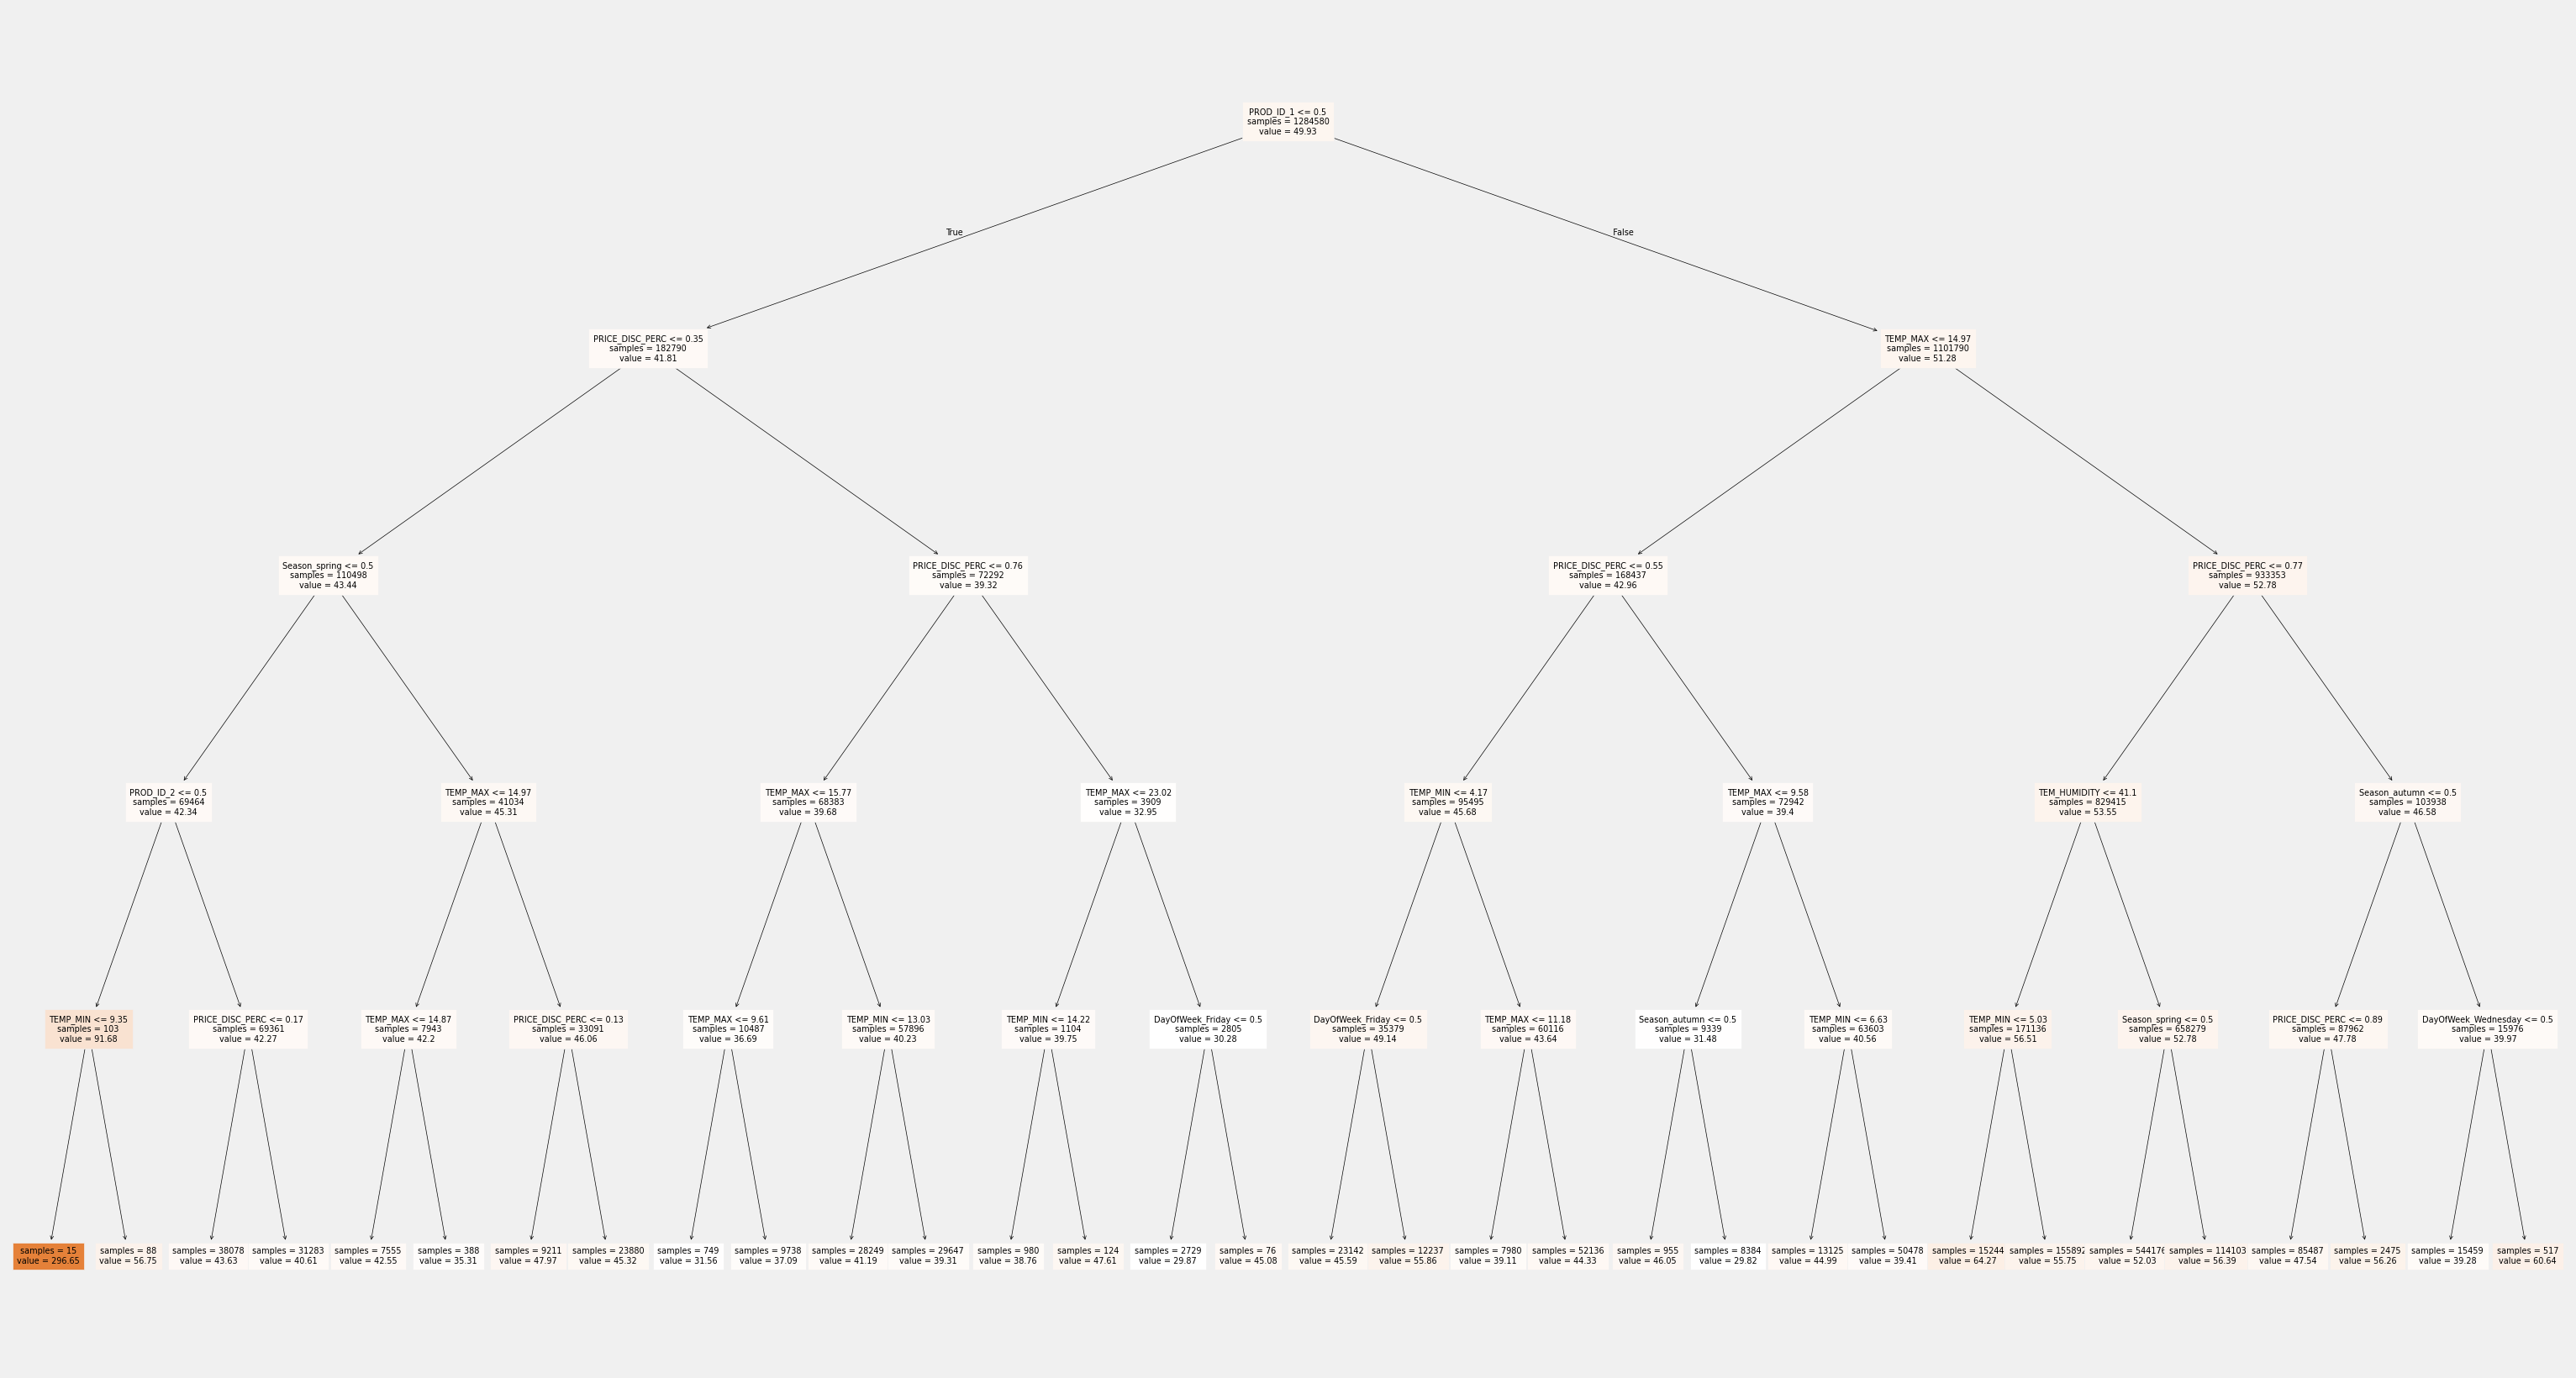

Reglas de decisión modelo inicial:
|--- PROD_ID_1 <= 0.50
|   |--- PRICE_DISC_PERC <= 0.35
|   |   |--- Season_spring <= 0.50
|   |   |   |--- PROD_ID_2 <= 0.50
|   |   |   |   |--- TEMP_MIN <= 9.35
|   |   |   |   |   |--- value: [296.65]
|   |   |   |   |--- TEMP_MIN >  9.35
|   |   |   |   |   |--- value: [56.75]
|   |   |   |--- PROD_ID_2 >  0.50
|   |   |   |   |--- PRICE_DISC_PERC <= 0.17
|   |   |   |   |   |--- value: [43.63]
|   |   |   |   |--- PRICE_DISC_PERC >  0.17
|   |   |   |   |   |--- value: [40.61]
|   |   |--- Season_spring >  0.50
|   |   |   |--- TEMP_MAX <= 14.97
|   |   |   |   |--- TEMP_MAX <= 14.87
|   |   |   |   |   |--- value: [42.55]
|   |   |   |   |--- TEMP_MAX >  14.87
|   |   |   |   |   |--- value: [35.31]
|   |   |   |--- TEMP_MAX >  14.97
|   |   |   |   |--- PRICE_DISC_PERC <= 0.13
|   |   |   |   |   |--- value: [47.97]
|   |   |   |   |--- PRICE_DISC_PERC >  0.13
|   |   |   |   |   |--- value: [45.32]
|   |--- PRICE_DISC_PERC >  0.35
|   |   |--

In [ ]:
print(f"\nCreando modelo Árbol de regresión para el dataset unificado:")

# Preprocesamos el dataframe que usaremos para el modelo
df_ajustado = preprocessor.fit_transform(df_c)   
    
# Especificamos las variables predictoras y objetivo
x = df_ajustado.drop(columns=['PRICE_FINAL'] )
y = df_ajustado['PRICE_FINAL']
    
# División de los datos en train (80%) y test (20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1, shuffle=True)

# Creación del modelo inicial
modelo_T = DecisionTreeRegressor(
    max_depth=5,
    random_state=123
)

# Entrenamiento del modelo inicial
modelo_T.fit(x_train, y_train)

# Estructura del árbol creado
fig, ax = plt.subplots(figsize=(35, 20))
print(f"Profundidad del árbol: {modelo_T.get_depth()}")
print(f"Número de nodos terminales: {modelo_T.get_n_leaves()}")

plot_tree(
    decision_tree=modelo_T,
    feature_names=list(x_train.columns),
    filled=True,
    impurity=False,
    fontsize=7,
    precision=2,
    ax=ax
)

# Guardamos la imagen con alta calidad
plt.savefig(f"arbol_decision.png", dpi=300, bbox_inches='tight')
plt.show()

# Explicabilidad del modelo
# Reglas de decisión
texto_modelo_T = export_text(
    decision_tree=modelo_T,
    feature_names=list(x_train.columns)
)
print('Reglas de decisión modelo inicial:')
print(texto_modelo_T)

# Importancia de los predictores
importancia_predictores_T = pd.DataFrame(
    {'predictor': x_train.columns, 'importancia': modelo_T.feature_importances_}
)
print("Importancia de los predictores en el modelo inicial")
print("-------------------------------------------")
print(importancia_predictores_T.sort_values('importancia', ascending=False))

# Pruning (cost complexity pruning) por validación cruzada
param_grid = {'ccp_alpha': np.linspace(0, 80, 20)}

grid = GridSearchCV(
    estimator=DecisionTreeRegressor(
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=123
    ),
    param_grid=param_grid,
    cv=10,
    refit=True,
    return_train_score=True
)

grid.fit(x_train, y_train)

# Mejor valor ccp_alpha encontrado
print('Mejores parámetros encontrados:')
print(grid.best_params_)

# Estructura del árbol final
modelo_final_T = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final_T.get_depth()}")
print(f"Número de nodos terminales: {modelo_final_T.get_n_leaves()}")

fig, ax = plt.subplots(figsize=(10, 7))
plot_tree(
    decision_tree=modelo_final_T,
    feature_names=list(x_train.columns),
    filled=True,
    impurity=False,
    fontsize = 10,
    ax=ax
)

# Guardamos la imagen con alta calidad
plt.savefig(f"arbol_decision_podado.png", dpi=300, bbox_inches='tight')
plt.show()

# Explicabilidad del modelo
# Reglas de decisión
#texto_modelo_final_T = export_text(
#    decision_tree=modelo_final_T,
#    feature_names=list(x_train.columns)
#)
#print('Reglas de decisión modelo final:')
#print(texto_modelo_final_T)

importancia_predictores_final_T = pd.DataFrame(
    {'predictor': x_train.columns, 'importancia': modelo_final_T.feature_importances_}
)
print("Importancia de los predictores en el modelo final")
print("-------------------------------------------")
print(importancia_predictores_final_T.sort_values('importancia', ascending=False))


# Error de test del modelo inicial
predicciones = modelo_T.predict(x_test)
rmse = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)
print(f"El error (rmse) de test del modelo inicial es: {rmse}")

# Error de test del modelo final (tras aplicar pruning)
predicciones = modelo_final_T.predict(x_test)
rmse = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)
print(f"El error (rmse) de test del modelo final es: {rmse}")

## Modelo 2: Random Forest

In [ ]:
print(f"\nCreando modelo bosque de regresión para el dataset unificado:")

# Preprocesamos el dataframe que usaremos para el modelo
df_ajustado = preprocessor.fit_transform(df_c)   

# Especificamos las variables predictoras y objetivo
x = df_ajustado.drop(columns=['PRICE_FINAL'])
y = df_ajustado['PRICE_FINAL']

# División de los datos en train (80%) y test (20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1, shuffle=True)

# Creación del modelo inicial
modelo_RF = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 1,
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo_RF.fit(x_train, y_train)

# Error de test del modelo inicial
# ==============================================================================
predicciones_RF = modelo_RF.predict(X=x_test)
mse = mean_squared_error(y_true=y_test, y_pred=predicciones_RF)
rmse = np.sqrt(mse)
print(f"El error (rmse) de test del primer modelo es: {rmse}")

# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20]
                }

# Creamos el GridSearchCV
grid_search = GridSearchCV(
    estimator=modelo_RF,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# Ajustamos el modelo
grid_search.fit(x_train, y_train)

# Resultados de los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Modelo final
modelo_final_RF = grid_search.best_estimator_

# Predicciones y evaluación
predicciones = modelo_final_RF.predict(x_test)
mse = mean_squared_error(y_test, predicciones)
rmse = np.sqrt(mse)
print(f"El error (rmse) de test del modelo mejorado es: {rmse}")

# Importancia de los predictores basada en la reducción de la impureza
importancia_predictores = pd.DataFrame({
    'predictor': x_train.columns,
    'importancia': modelo_final_RF.feature_importances_
})
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
print(importancia_predictores.sort_values('importancia', ascending=False))

# Explicabilidad
# ==============================================================================
# Explicabilidad del modelo inicial
# Fits the explainer
explainer = shap.Explainer(modelo_RF.predict, x_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test)
print("Explicabilidad del modelo inicial:")
shap.plots.bar(shap_values)

# Explicabilidad del modelo final
# Fits the explainer
explainer = shap.Explainer(modelo_final_RF.predict, x_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test)
print("Explicabilidad del modelo final:")
shap.plots.bar(shap_values)